# Simulation sanity checks
> Verifying that `src/simulation.py` does what I want it to (informal)

I'm going through a couple sanity checks on simulation here:

In [29]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from src.simulation import ptr_curve, simulate_from_ids
# from src.torch_solver import TorchSolver
from src.solve_table import solve_all
from src.database import RnaDB

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PTR curve works:

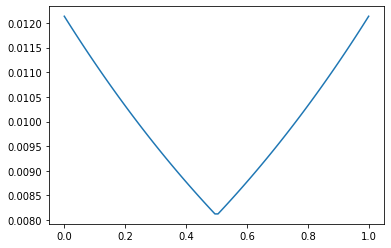

In [31]:
# Case where OOR is at 0

x, y = ptr_curve(100, 1.5, 0)
plt.plot(x, y, label="a=1.5, b=0")

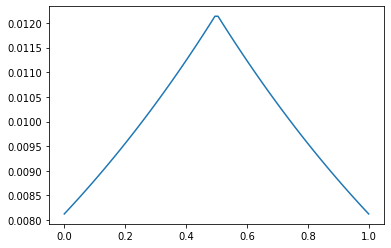

In [32]:
# Case where OOR is at 0.5

x, y = ptr_curve(100, 1.5, 50)
plt.plot(x, y, label="a=1.5, b=50")

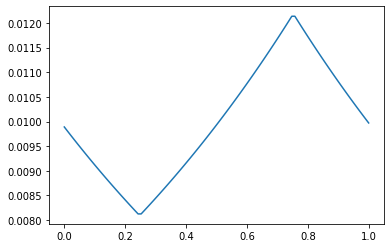

In [33]:
# Case where OOR is at 0.25

x, y = ptr_curve(100, 1.5, 25)
plt.plot(x, y, label="a=1.5, b=25")

# Simulate some stuff

In [38]:
full_db = RnaDB()
db = full_db.db

sample_genomes = np.random.choice(db[db["n_contigs"] == 1]["genome"].unique(), 10, replace=False)
samples, ptrs, coverages, otus = simulate_from_ids(
    db=db,
    ids=sample_genomes,
    fasta_path="/home/phil/aptr/data/seqs",
    n_samples=1,
    scale=1e6,
    shuffle=False,  # Suppress shuffling to conserve memory
    fastq=False, # Don't generate reads
)

/home/phil/miniconda3/envs/aPTR/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/phil/miniconda3/envs/aPTR/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Generating sample 0 for organism 504728.9...
Generating sample 0 for organism 904294.3...
Generating sample 0 for organism 313595.4...
Generating sample 0 for organism 572479.3...
Generating sample 0 for organism 358681.3...
Generating sample 0 for organism 267747.3...
Generating sample 0 for organism 1150469.3...
Generating sample 0 for organism 595494.3...
Generating sample 0 for organism 314232.4...
Generating sample 0 for organism 98228.3...


In [39]:
def score_simulation(otus, ptrs, **kwargs):
    otu_df = pd.DataFrame(otus).sum()
    otu_df.to_csv("/tmp/otus.tsv", sep="\t")

    ptr_guess, abundance_guess = solve_all(**kwargs)

    # This is for comparisons
    ptrs_indexed = pd.DataFrame(ptrs[:,0], index=sample_genomes)
    ptrs_indexed.index.name = "genome"
    ptrs_indexed.columns.name = "sample"

    ptr_errors = (ptrs_indexed.values - ptr_guess.reindex(ptrs_indexed.index).values)
    return np.square(ptr_errors)


In [40]:
score_simulation(
    otus=otus,
    ptrs=ptrs,
    otu_table_path="/tmp/otus.tsv",
    db_path="/home/phil/aptr/experiments/simulated_complete/1e5/aptr_out/db.pkl",
    torch=False,
    n_epochs=100000
)

array([[0.01888732],
       [0.0648112 ],
       [0.06933409],
       [0.0095516 ],
       [0.25854336],
       [0.3683336 ],
       [0.01606408],
       [0.06856981],
       [0.25989846],
       [0.01856997]])

# Simulation scaling

In [85]:
scores = []
for scale_exp in range(8):
    i = 10 ** scale_exp
    print(f"Scale: {i}")
    samples, ptrs, coverages, otus = simulate_from_ids(
        db=db,
        ids=sample_genomes,
        fasta_path="/home/phil/aptr/data/seqs",
        n_samples=1,
        scale=i,
        shuffle=False,  # Suppress shuffling to conserve memory
        fastq=False,
        verbose=False, # Shut up
    )
    score = score_simulation(
        otus=otus,
        ptrs=ptrs,
        otu_table_path="/tmp/otus.tsv",
        db_path="/home/phil/aptr/experiments/simulated_complete/1e5/aptr_out/db.pkl",
        torch=True,
        n_epochs=100000
    )
    scores.append(score)
    print(f"Score: {score}")
    print()


Scale: 1
Score: []

Scale: 10
Score: []

Scale: 100
Score: []

Scale: 1000
Score: []

Scale: 10000
Score: [[       nan]
 [0.09579336]
 [0.30132163]
 [       nan]
 [       nan]
 [       nan]
 [0.10846392]
 [       nan]
 [0.31477981]
 [       nan]]

Scale: 100000
Score: [[0.01508388]
 [       nan]
 [0.00198458]
 [0.27516141]
 [0.33325729]
 [0.20879681]
 [0.4421714 ]
 [       nan]
 [0.06819864]
 [0.37525099]]

Scale: 1000000
Score: [[0.26871463]
 [0.11080181]
 [0.04330194]
 [0.40192765]
 [0.14662168]
 [0.04970526]
 [0.61084792]
 [0.02743372]
 [0.04962396]
 [0.06814436]]

Scale: 10000000
Score: [[0.62439375]
 [0.02571619]
 [0.12633841]
 [0.0056125 ]
 [0.12033921]
 [0.44465053]
 [0.19571205]
 [0.65305511]
 [0.33753763]
 [0.63196378]]



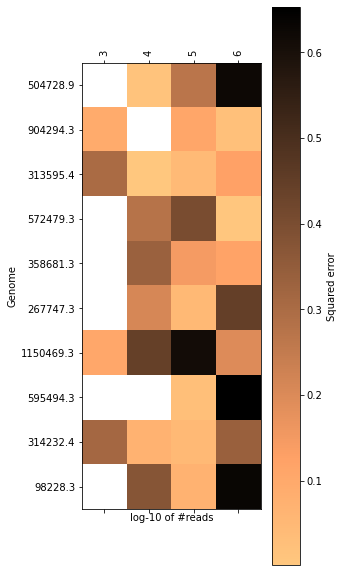

In [92]:
score_array = np.array([s.flatten() for s in scores if len(s.flatten()) > 0]).T

plt.matshow(score_array, cmap="copper_r")

plt.ylabel("Genome")
plt.xlabel("log-10 of #reads")
plt.yticks(range(len(sample_genomes)), sample_genomes)
plt.xticks(range(4), range(3,7), rotation=90) 
# Magic numbers: 3, 10 are the scales for which we get estimates

plt.colorbar(label = "Squared error")
plt.show()

In [82]:
score_array

array([[8.26631946e+00, 8.42396470e-02, 1.08610736e-01, 4.15467898e-02],
       [           nan, 3.31126467e-01, 1.44746323e-01,            inf],
       [           nan, 5.23303134e-03, 1.40009839e+04, 2.32695428e+10],
       [4.52839011e+00, 9.94247905e-01, 5.95210489e+00,            inf],
       [           nan, 8.79580860e-01, 3.35025337e-01,            inf],
       [           nan, 2.70415383e+00, 4.75727611e-01,            inf],
       [1.85450629e-02, 1.14534452e+00, 2.82980137e+00, 8.94903741e-01],
       [9.49144332e+01, 1.87582916e-01, 1.82090293e+01, 3.52735606e-01],
       [2.75642298e-01, 6.41662811e-01, 8.22105094e-02, 2.24923957e-01],
       [3.41248388e-04, 2.18554133e+01, 8.66734621e-01,            inf]])

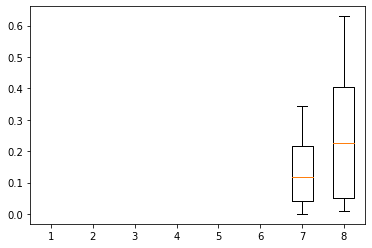

In [45]:
plt.boxplot([s.flatten() for s in scores])
plt.show()